In [ ]:
"""
Table 1
"""

In [1]:
#Import packages to facilitate this research
import os, random
SEED = 1                                
os.environ["PYTHONHASHSEED"]  = str(SEED) 
os.environ["TF_DETERMINISTIC_OPS"] = "1" 
random.seed(SEED)  
import numpy as np 
np.random.seed(SEED)    
import tensorflow as tf #(https://www.tensorflow.org/install)
tf.keras.utils.set_random_seed(SEED)      
tf.config.experimental.enable_op_determinism() 
from tensorflow.keras import (layers,Model) 
from tensorflow.keras.layers import (Layer, Input, Dense, Concatenate, Activation, TimeDistributed,
Flatten, Lambda, GlobalAveragePooling1D, LeakyReLU) 
from tensorflow.keras.utils import to_categorical 
from concretedropout.tensorflow import (ConcreteDenseDropout, ConcreteSpatialDropout1D, # https://github.com/aurelio-amerio/ConcreteDropout
get_weight_regularizer, get_dropout_regularizer) 
from sktime.classification.deep_learning import InceptionTimeClassifier #https://www.sktime.net/en/stable/get_started.html
from sktime.classification.ensemble import BaggingClassifier
from aeon.classification.convolution_based import MultiRocketHydraClassifier #https://www.aeon-toolkit.org/en/stable/installation.html
from aeon.classification.early_classification import TEASER
from aeon.classification.hybrid import HIVECOTEV2
from sklearn.metrics import (accuracy_score, mean_absolute_error, mean_squared_error,  # https://scikit-learn.org/stable/install.html
classification_report)
from sklearn.model_selection import train_test_split
from math import comb
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from statsmodels.stats.contingency_tables import mcnemar
from tensorflow.keras.layers import Reshape

/opt/anaconda3/lib/python3.12/site-packages/aeon/base/__init__.py:24: FutureWarning: The aeon package will soon be releasing v1.0.0 with the removal of legacy modules and interfaces such as BaseTransformer and BaseForecaster. This will contain breaking changes. See aeon-toolkit.org for more information. Set aeon.AEON_DEPRECATION_WARNING or the AEON_DEPRECATION_WARNING environmental variable to 'False' to disable this warning.
  warnings.warn(


In [2]:
G = 9.81  # Gravitational constant 
DT = 0.025 #Discretize continous time into 0.025 time intervals        
M = 10 #Number of observed ball positions  
K = 60 #Number of future ball positions 
N = 10_000 #Number of trajectories 
SEED = 42 #random seed
rng = np.random.default_rng(SEED) #random seed
ZONE_X = (12.0, 14.0) #Current zone of player 
WAIST_H = 1.00 #Height used for label determination
EPSILON = 0.025 #Grey band interval 
ALPHA = 0.20 # Weight given to grey-band samples
def simulate_throw(dt=DT, m=M, k=60, g=G, rng=rng):
    """
    Simulate someone throwing a ball towards the player 
    """
    tot = m + k #Total number of time frames to simulate
    v0 = rng.uniform(10, 15) #Generate the initial velocity of the throw at random from a uniform(10,15) distributed random variable
    theta = np.deg2rad(rng.uniform(20, 40)) #Angle of projection
    vx, vy = v0 * np.cos(theta), v0 * np.sin(theta) #Horizontal and vertical components of velocity
    x, y = 0.0, rng.uniform(1.0, 1.1) #Setting the initial horizontal starting point of the ball to 0m and generate the initial height the ball is thrown from a uniform(1,1.1) distributed random variable
    base_wind = rng.normal(0.0, 1.0)  #Generate a baseline level of wind form a standard normal distributed random variable
    wind_change = rng.normal(0.0, 6.0)  # Generate additional wind perturbation
    traj = np.empty((tot, 2), np.float32) #Create an array which will store the (x,y) coordinates of the trajectory 
    for t in range(tot): #Simulate (x,y) coordinates of trajectory 
        traj[t, 0] = x + rng.normal(0, 0.15)  #Initial x coordinate of the trajectory at time t plus observation error which is given by a Normal(0,0.15) distributed random variable
        traj[t, 1] = y + rng.normal(0, 0.15) #Initial y coordinate of the trajectory at time t plus observation error which is given by a Normal(0,0.15) distributed random variable
        if y <= 0: #If the ball lands set the rest of the trajectories to zero and stop the simulation 
            traj[t:, 1] = 0.0
            break
        if t*dt > 0.25: #If we have observed more than 0.25 seconds of the objects trajectory
            wind = base_wind + wind_change #Compute overall level of wind 
            drag = rng.uniform(0.08, 0.12) #Simulate drag from a uniform(0.08,0.12) distributed random variable 
        else:
            wind = base_wind #base level of wind
            drag = rng.uniform(0.03, 0.05) #Simulate drag from a uniform(0.03,0.05) distributed random variable 
        ax = wind - drag * vx #Compute the horizontal component of acceleration 
        ay = -g - drag * vy #Compute the vertical component of acceleration 
        vx += ax * dt #Compute horizontal component of velocity using Euler's method 
        vy += ay * dt #Compute vertical  component of velocity using Euler's method
        x += vx * dt #Compute x coordinate using Euler's method 
        y += vy * dt #Compute y coordinate using Euler's method
    return traj[:m], traj[m:m+k]
obs, fut = zip(*(simulate_throw() for _ in range(N))) #Build data set
X_obs = np.stack(obs,  axis=0) #Observed part of each simulated trajectory 
X_future = np.stack(fut,  axis=0) #Future part of each simulated trajectory 
x_fut = X_future[..., 0] #X-coordinates of future observations 
y_fut = X_future[..., 1] #Y-coordinates of future observations 
in_zone = (x_fut >= ZONE_X[0]) & (x_fut <= ZONE_X[1]) #Returns 1 if the ball is in the players zone
h_zone  = np.where(in_zone, y_fut, -1.0).max(axis=1) #Maximum height of the ball inside the players zone
y_class       = (h_zone >= WAIST_H).astype(int) #If ball is "too high" the ball is in class 1, otherwise it is in class 0 
border        = np.abs(h_zone - WAIST_H) < EPSILON #Can be used for borderline trajectories but is not used in this work
sample_weight = np.ones_like(h_zone, dtype=np.float32) #Can be used for borderline trajectories but is not used in this work
sample_weight[border] = ALPHA #Can be used for borderline trajectories but is not used in this work
print(f"Total trajectories      : {N:,}") #Prints the total number of trajectories 
print(f"Grey-band (down-weighted): {border.sum():,}") #Number of borderline cases
Xo_tr, Xo_te, Xf_tr, Xf_te, yc_tr, yc_te, sw_tr, sw_te = train_test_split(
        X_obs, X_future, y_class, sample_weight,test_size=0.20, random_state=SEED, stratify=y_class) #Create a train test split 
print("Train shapes  Xo_tr:", Xo_tr.shape, " positives:", yc_tr.sum(), "/", len(yc_tr)) #Print the shape of the training data and the proportion of training examples in class 1 
print(" Test shapes  Xo_te:", Xo_te.shape," positives:", yc_te.sum(), "/", len(yc_te)) #Print the shape of the test data and the proportion of examples in class 1 

Total trajectories      : 10,000
Grey-band (down-weighted): 61
Train shapes  Xo_tr: (8000, 10, 2)  positives: 3899 / 8000
 Test shapes  Xo_te: (2000, 10, 2)  positives: 975 / 2000


In [3]:
X_observed_train = Xo_tr 
X_observed_test = Xo_te
X_forecast_train = Xf_tr 
X_forecast_test = Xf_te
y_train = to_categorical(yc_tr,num_classes = 3) #One hot encode training data labels 
y_test = to_categorical(yc_te,num_classes = 3) #One hot encode test data labels
print(X_observed_train.shape)
print(X_observed_test.shape)
print(X_forecast_train.shape)
print(X_forecast_test.shape)
print(y_train.shape)
print(y_test.shape)

(8000, 10, 2)
(2000, 10, 2)
(8000, 60, 2)
(2000, 60, 2)
(8000, 3)
(2000, 3)


In [4]:
Ns = X_observed_train.shape[0] #Number of time series 
time_steps = X_observed_train.shape[1] #Number of time steps per time series
n_forecast = X_forecast_train.shape[1] #Number of steps ahead for the forecasts
n_classes = y_train.shape[1] #Number of classes 
wr = get_weight_regularizer(Ns, l=1e-2, tau=0.5) #Determines the amount of regularization on the weights in the concrete dropout layers of ForeClassNet
dr = get_dropout_regularizer(Ns, tau=0.5, cross_entropy_loss=True) #Determines the amount of regularization on the dropout probabilities of ForeClassNet

In [5]:
n_features = X_observed_train.shape[2] #Number of features in the time series 
def create_custom_filters(filter_length, input_channels=n_features):
    """
    Function that takes in a user specified filter length to then construct hand-crafted filters 
    according to (4)-(6) in Section 5 of the research paper. 
    """
    filter_1 = np.array([(-1) ** (i + 1) for i in range(filter_length)], dtype=np.float32) #Decreasing filter
    filter_2 = np.array([(-1) ** i for i in range(filter_length)], dtype=np.float32) #Increasing filter
    filter_3 = np.zeros(filter_length, dtype=np.float32) #Peaks filter

    for n in range(0, int(((filter_length - 3) / 3) + 1)):
        filter_3[n] = (-3 / filter_length) * comb(int((filter_length - 3) / 3), n)
    for n in range(int(filter_length / 3), int((2 * (filter_length - 3) / 3) + 2)):
        filter_3[n] = (6 / filter_length) * comb(int((filter_length - 3) / 3), int(n - (filter_length / 3)))
    for n in range(int((2 * (filter_length - 3) / 3) + 2), filter_length):
        filter_3[n] = (-3 / filter_length) * comb(int((filter_length - 3) / 3), int(n - (2 * (filter_length - 3) / 3) - 2))
    base_filters = np.stack([filter_1, filter_2, filter_3], axis=-1) #Combine the filters together
    base_filters = np.repeat(base_filters[:, np.newaxis, :], input_channels, axis=1) #Replicate  filters for each dimension of the time series
    return base_filters.astype(np.float32)
class WelfordMeanVarianceLayer(Layer): #Defining the Welford Mean-variance layer (section 4.2) as a subclass of Layer in Keras
    def __init__(self, total_series,n_features, n_forecast=4, **kwargs): #Constructor of the class, where it takes in the number of time series we want to have mean and variance estimates for and the number of forecasts for each
        super(WelfordMeanVarianceLayer, self).__init__(**kwargs) #Calls the Keras layer class
        self.total_series = total_series #Number of series the layer will track 
        self.n_forecast = n_forecast #Number of forecast steps ahead
        self.stats = self.add_weight( #Creates a non-trainable tensor to store the means and variances which is initialized with zeros
            shape=(self.total_series, self.n_forecast,n_features, 2),
            initializer="zeros",
            trainable=False,
            name="stats"
        ) 
        self.count = self.add_weight( #Creates a non-trainable tensor to count how many samples for the mean and variance we have for the forecasts of a given time series, which are obtained through successive forward passes
            shape=(self.total_series,),
            initializer="zeros",
            trainable=False,
            name="count"
        )
    def reset_statistics(self): #A method to clear the existing estimates of the mean and variance of the forecasts and set them to zero, which you might want to do during testing
        self.stats.assign(tf.zeros_like(self.stats))
        self.count.assign(tf.zeros_like(self.count))
    def call(self, inputs, **kwargs): #Main method used when calling the Welford layer in a given forward pass
        forecast_values, series_ids = inputs  #Unpacks the inputs into the Welford layer, the forecast values in the current forward pass and the ids of the current time series being processed 
        batch_size = tf.shape(forecast_values)[0] #Derives the current batch size from the shape of the forecast values tensor
        def loop_body(i, current_stats, current_count): #Defines the body of a while loop to be used in the proceeding lines. Processes the ith time series in the batch by applying Welford's algorithm 
            idx = series_ids[i] #Determines the id of the current time series being processed       
            val = forecast_values[i] #The values to be used to update the means and variances of the forecasts
            current_count = tf.tensor_scatter_nd_add(current_count, [[idx]], [1.0]) #Increments the count of the number of times we have updated the mean and variance of the given time series 
            old_mean = current_stats[idx, :, :, 0]  #Extracts the old forecast means 
            old_var  = current_stats[idx, :, :, 1] #Extracts the old forecast variance  
            n = current_count[idx] #Number of times we have updated the mean and variance of the forecasts for a given time series
            delta = val - old_mean #The difference between the new forecast value and the old mean
            new_mean = old_mean + (delta /n) #Formula used in Welford's algorithm to update the mean
            delta2 = val - new_mean #Difference between the new forecast value and the new mean 
            new_var = ((1-(1/n))*old_var) + ((delta*delta2)/n) #Update the value of the sample variance using the population variance formula      
            updated_stats = tf.stack([new_mean, new_var], axis=-1) #Combines the new values of the sample mean and variance
            current_stats = tf.tensor_scatter_nd_update(current_stats, [[idx]], [updated_stats]) #Overwrites the old values of the mean and variance for a given time series with the new values of the mean and variance 
            return i+1, current_stats, current_count #Set i to i+1 to go to the next time series in the batch, and return the current values of the sample mean and variance, and the number of times the time series have been processed
        i0 = tf.constant(0) #Starting index of the loop 
        stats0 = self.stats #The initial stats for the start of the while loop 
        count0 = self.count #The initial counts that each time series has been processed for the start of the while loop
        _, updated_stats, updated_count = tf.while_loop( #The while loop which outputs the index, the updated stats, and the updated counts
            cond=lambda i, *_: i < batch_size, #Determines if the while loop should continue or not, where the loop stops if i exceeds the batch size as there are no more time series to process in the current batch 
            body=loop_body, #Using the function defined earlier which is used in each iteration of the while loop
            loop_vars=[i0, stats0, count0] #Initial values of the variables in the while loop 
        )
        self.stats.assign(updated_stats) #Permanently updates the stats variable of the layer which will be used in future calls of the layer
        self.count.assign(updated_count) #Permanently updates the count variable for the layer which will be used in future calls of the layer 
        out_stats_for_batch = tf.gather(self.stats, series_ids) #Takes the means and variances for the forecasted time points for the time series in the current batch so they can be passed to the proceeding layer 
        return out_stats_for_batch #Returns the means and variances for the forecasted time series in the current batch so they can be passed into the next layer of the network in the current forward pass
class BoltzmannConv1D(Layer): #Defining the Boltzmann convolutional layer (section 4.1) as a subclass of Layer in Keras
    def __init__(self, out_channels, kernel_sizes, dilation_rate=1, padding="causal", temperature=1, **kwargs):#Contructor of the class which takes in several hyperparameters including the type of padding, dilation rate, and temperature of the Boltzmann distribution
        super(BoltzmannConv1D, self).__init__(**kwargs) #Calls the Keras layer class
        self.out_channels = out_channels #Number of output channel
        self.kernel_sizes = kernel_sizes #The set of kernel filter lengths 
        self.dilation_rate = dilation_rate #Dilation rate of the layer  
        self.padding = padding #Type of padding for the layer 
        self.temperature = temperature #Value of the temperature for the Boltzmann distribution 
        self.convs = [  #Creates a list consisting of sub-convolutional layers with the parameters defined above. The layer is wrapped in a Spatial Concrete Dropout layer 
            ConcreteSpatialDropout1D(
                tf.keras.layers.Conv1D(
                    out_channels, ks,
                    dilation_rate=dilation_rate,
                    padding=padding
                ),
                is_mc_dropout=True,
                weight_regularizer=wr,
                dropout_regularizer=dr
            )
            for ks in kernel_sizes #Iterates over the filter lengths in the kernel_sizes list creating associated convolutional layers
        ]
    def build(self, input_shape): #Create the weights used in the layers 
        self.probs = self.add_weight(   #Logits used in the Boltzmann distribution  which are learnable 
            shape=(len(self.kernel_sizes),),
            initializer="uniform",
            trainable=True,
            name="kernel_probs"
        )
        super(BoltzmannConv1D, self).build(input_shape) #Finalizes the build methods by inheriting the build from the overall Keras layer class
    def call(self, x, training=False): #Main method used when calling the Boltzmann layer for a given forward pass
        kernel_probabilities = tf.nn.softmax(self.probs / self.temperature) #Defines the probability discussed in section 4.1 
        conv_outputs = [ #Creates the list of the weighted convolution outputs
            conv(x) * kernel_prob
            for conv, kernel_prob in zip(self.convs, tf.unstack(kernel_probabilities)) #Turns the kernel probabilities into a list which are then paired with their associated convolutional layer, with them being multiplied together 
        ]
        out = tf.add_n(conv_outputs) #Sums up the weighted convolutional outputs in the list
        return out #Returns the summed output of the weighted convolutional layers according to (2) in section 4.1
class PredefinedBoltzmannConv1D(Layer):
    def __init__(self, filters, kernel_sizes, dilation_rate, custom_filters, temperature=1, **kwargs):
        super(PredefinedBoltzmannConv1D, self).__init__(**kwargs)
        self.filters = filters #Number of filters
        self.kernel_sizes = kernel_sizes #The set of kernel filter lengths
        self.temperature = temperature #Value of the temperature for the Boltzmann distribution 
        self.custom_filters = custom_filters #Pre-defined filters as described in section 5
        self.dilation_rate = dilation_rate #Dilation rate of the layer
        self.convs = []
        for ks in kernel_sizes:
            conv_layer = tf.keras.layers.Conv1D(
                filters=filters,
                kernel_size=ks,
                padding="causal",
                use_bias=False,
                dilation_rate=dilation_rate
            )
            self.convs.append(conv_layer) #Creates a list consisting of sub-convolutional layers with hand-crafted filters with different filter lengths
    def build(self, input_shape):
        for i, (conv_layer, ks) in enumerate(zip(self.convs, self.kernel_sizes)): #Create the weights used in the layers
            conv_layer.build(input_shape)
            filter_weights = self.custom_filters[ks]
            conv_layer.set_weights([filter_weights])
            conv_layer.trainable = False
        self.probs = self.add_weight( #Logits used in the Boltzmann distribution  which are learnable
            shape=(len(self.kernel_sizes),),
            initializer="uniform",
            trainable=True,
            name="kernel_probs"
        )
        super(PredefinedBoltzmannConv1D, self).build(input_shape)
    def call(self, x, training=False): #Main method used when calling the hand-crafted Boltzmann layer for a given forward pass
        kernel_probabilities = tf.nn.softmax(self.probs / self.temperature)
        conv_outputs = [
            conv(x) * kernel_prob
            for conv, kernel_prob in zip(self.convs, tf.unstack(kernel_probabilities))
        ]
        out = tf.add_n(conv_outputs)
        return out

In [6]:
kernel_sizes = [3,6,9] #Pre-defined filter lengths (section 5)
custom_filters_dict = {ks: create_custom_filters(ks) for ks in kernel_sizes} #Pre-defined filter weights as a function of filter length (4)-(6) in section 5
ts_input = Input(shape=(time_steps, n_features), name="ts_input")   #Defining the input time series to ForeClassNet      
series_id_input = Input(shape=(), dtype=tf.int32, name="series_id")   #Defining the input time series index to ForeClassNet

#Parallel layer and concatenation layer#
conv_predefined = PredefinedBoltzmannConv1D(filters=3, kernel_sizes=kernel_sizes,dilation_rate=1, custom_filters=custom_filters_dict)
x1 = conv_predefined(ts_input)
x1 = Activation("relu", name="activation_predefined")(x1)
x2 = BoltzmannConv1D(out_channels=128, kernel_sizes=kernel_sizes, dilation_rate=1)(ts_input)
x2 = Activation("relu", name="activation_learnable")(x2)
concatenated = Concatenate(axis=-1)([x1, x2])

#Boltzmann Convolutional layer#
x3 = BoltzmannConv1D(out_channels=64, kernel_sizes=kernel_sizes, dilation_rate=2)(concatenated)
x3 = Activation("relu")(x3)

#Boltzmann convolutional layer#
x4 = BoltzmannConv1D(out_channels=32, kernel_sizes=kernel_sizes, dilation_rate=4)(x3)
x4 = Activation("relu")(x4)

#Time distributed dense layer#
layer_4 = Dense(n_features, use_bias=False)
layer_4 = ConcreteDenseDropout(layer_4, is_mc_dropout=True, weight_regularizer=wr, dropout_regularizer=dr)
x5 = TimeDistributed(layer_4)(x4)  
x5_reshaped = Reshape((time_steps, n_features))(x5)
x5_expanded = Lambda(lambda x: tf.expand_dims(x, axis=-1))(x5_reshaped)
zeros_tensor = Lambda(lambda x: tf.zeros_like(x))(x5_expanded)
x6_final = Concatenate(axis=-1)([x5_expanded, zeros_tensor])

#Fully connected layer#
layer_6 = Dense(32, use_bias=True)  
layer_6 = ConcreteDenseDropout(layer_6, is_mc_dropout=True,weight_regularizer=wr, dropout_regularizer=dr)
x5_flat = Flatten()(x5)    
x8 = layer_6(x5_flat)
x8 = LeakyReLU(negative_slope=0.01)(x8)

#Fully connected layer and forecast output#
layer_7 = Dense(n_forecast*n_features, use_bias=True)
layer_7 = ConcreteDenseDropout(layer_7, is_mc_dropout=True, weight_regularizer=wr, dropout_regularizer=dr,name="output_forecast")
output_forecast = layer_7(x8)
output_forecast = Reshape((n_forecast, n_features))(output_forecast)

#Welford layer and concatenation layer#
num_series = 10000
welford_forecast_layer = WelfordMeanVarianceLayer(total_series=num_series,n_forecast= n_forecast, n_features=n_features , name="Welford")
output_forecast_final = welford_forecast_layer([output_forecast, series_id_input])
concatenated_2 = Concatenate(axis=1)([x6_final, output_forecast_final])
concatenated_2_flat = Reshape(((X_observed_train.shape[1] + X_forecast_train.shape[1]), 4))(concatenated_2)


#Boltzmann convolutional layer and GAP layer#
x_classification = BoltzmannConv1D(out_channels=32, kernel_sizes=kernel_sizes,dilation_rate=8)(concatenated_2_flat)
x_classification = Activation("relu")(x_classification)
x_classification = GlobalAveragePooling1D()(x_classification)


#Fully connected layer and classification output#
final_classification_layer = Dense(n_classes, use_bias=False)
final_classification_layer = ConcreteDenseDropout(final_classification_layer, is_mc_dropout=True, weight_regularizer=wr,
                                                  dropout_regularizer=dr,
                                                  name="classification_output")
output_classification = final_classification_layer(x_classification)
output_classification = Activation("softmax")(output_classification)

#compilation and summary of ForeClassNet#
model = Model(inputs=[ts_input, series_id_input],outputs=[output_forecast, output_classification]
              ,name="time_series_forecasting_classification_model")
model.compile(optimizer="adam",loss=["mse", "categorical_crossentropy"],metrics=["mse", "accuracy"])
model.summary()

Model: "time_series_forecasting_classification_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ts_input            │ (None, 10, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ predefined_boltzma… │ (None, 10, 3)     │        111 │ ts_input[0][0]    │
│ (PredefinedBoltzma… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ boltzmann_conv1d    │ (None, 10, 128)   │      4,998 │ ts_input[0][0]    │
│ (BoltzmannConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_predefi… │ (None, 10, 3)     │          0 │ predefined_boltz… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_learnab… │ (None, 10, 128)   │          0 │ boltzmann_conv1d… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 10, 131)   │          0 │ activation_prede… │
│ (Concatenate)       │                   │            │ activation_learn… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ boltzmann_conv1d_1  │ (None, 10, 64)    │    151,110 │ concatenate[0][0] │
│ (BoltzmannConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 10, 64)    │          0 │ boltzmann_conv1d… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ boltzmann_conv1d_2  │ (None, 10, 32)    │     36,966 │ activation[0][0]  │
│ (BoltzmannConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 10, 32)    │          0 │ boltzmann_conv1d… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 10, 2)     │         65 │ activation_1[0][… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 20)        │          0 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concrete_dense_dro… │ (None, 32)        │        673 │ flatten[0][0]     │
│ (ConcreteDenseDrop… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 32)        │          0 │ concrete_dense_d… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 10, 2)     │          0 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_forecast     │ (None, 120)       │      3,961 │ leaky_re_lu[0][0] │
│ (ConcreteDenseDrop… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 10, 2, 1)  │          0 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 60, 2)     │          0 │ output_forecast[

 Total params: 2,610,387 (9.96 MB)

 Trainable params: 200,279 (782.34 KB)

 Non-trainable params: 2,410,108 (9.19 MB)

In [7]:
#Train ForeClassNet
batch_size = 64 #Batch size used in optimization 
epochs = 100 #Number of epochs used in optimization
tic = time.perf_counter() #Time how long it takes for training
series_id_train = np.arange(Ns, dtype=np.int32) #Create an id for each time series in the test set which will be used in the Welford layer
model.fit(x=[X_observed_train, series_id_train],  y=[X_forecast_train, y_train], batch_size=batch_size,
    epochs=epochs,validation_split=0.1,shuffle=True) #Train ForeClassNet
toc = time.perf_counter()
print(f"Time taken for fitting: {toc - tic:.2f} seconds") #Prints the time it took ForeClassNet to train
time_in_mins = round((toc - tic) / 60)
print("Time in minutes:", time_in_mins)

Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - activation_3_accuracy: 0.4941 - activation_3_loss: 0.9184 - loss: 30.8879 - reshape_1_loss: 30.0512 - reshape_1_mse: 30.0517 - val_activation_3_accuracy: 0.4800 - val_activation_3_loss: 0.7159 - val_loss: 12.1174 - val_reshape_1_loss: 11.4252 - val_reshape_1_mse: 11.4833
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - activation_3_accuracy: 0.5024 - activation_3_loss: 0.7320 - loss: 12.0396 - reshape_1_loss: 11.3889 - reshape_1_mse: 11.3887 - val_activation_3_accuracy: 0.4925 - val_activation_3_loss: 0.6969 - val_loss: 10.9053 - val_reshape_1_loss: 10.2421 - val_reshape_1_mse: 10.2885
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - activation_3_accuracy: 0.5164 - activation_3_loss: 0.7347 - loss: 10.9687 - reshape_1_loss: 10.3145 - reshape_1_mse: 10.3143 - val_activation_3_accuracy: 0.5425 - val_activation_3_loss: 0.6864 - val_loss: 9.6781 - val_reshape_1_loss: 9.0389 - val_reshape_1_mse: 9.0711
Epoch 4/100
113/113

In [8]:
def mc_dropout_predict(model, X_test, test_ids, num_samples=100):
    """
    Peforms Monte Carlo dropout, where dropout is applied at inference time. 
    This takes as input the trained ForeClassNet model, the input observed time series, 
    the id's associated with the time series in the test set, and the number of MC samples which
    is the number of forward passes through the trained ForeClassNet model.
    """
    forecast_predictions = [] #List to store the forecast output from each forward pass through ForeClassNet
    classification_predictions = [] #List to store the classification output from each forward pass through ForeClassNet
    for _ in tqdm(range(num_samples), desc="MC Dropout passes"):
        forecast, classification = model.predict([X_test, test_ids], verbose=0) #Performs a forward pass through the network
        forecast_predictions.append(forecast) #Add the forecast array to the list  
        classification_predictions.append(classification) #Add the classification array of probabilities to the list
    forecast_predictions = np.array(forecast_predictions)
    classification_predictions = np.array(classification_predictions) 
    mean_forecast = np.mean(forecast_predictions, axis=0) #Take the mean with respect to the MC samples of the forecast output
    std_forecast = np.std(forecast_predictions, axis=0) #Take the standard deviation with respect to the MC samples of the forecast output
    mean_classification = np.mean(classification_predictions, axis=0) #Take the mean with respect to the MC samples of the classification probabilities
    std_classification = np.std(classification_predictions, axis=0) #Take the standard deviation with respect to the MC samples of the classification probabilities
    return (mean_forecast, std_forecast), (mean_classification, std_classification)

In [9]:
n_test_series = X_observed_test.shape[0] #Number of time series in the test set
test_series_ids = np.arange(n_test_series, dtype=np.int32) #Create an id for each time series in the test set for tracking in the Welford mean-variance layer
welford_forecast_layer = model.get_layer("Welford") 
welford_forecast_layer.reset_statistics() #Reset the statistics in the Welford layer

In [10]:
#Perform MC Dropout
(mean_forecast, forecast_uncertainty), (mean_classification, classification_uncertainty) = mc_dropout_predict(
    model,X_observed_test,    test_series_ids,    num_samples=100) #Perfrom 100 Monte Carlo passes through the trained ForeClassNet
predicted_classes = np.argmax(mean_classification, axis=-1) #Obtain the predicted classes 
print("Predicted classes:", predicted_classes)
classification_accuracy = accuracy_score(np.argmax(y_test, axis=1), predicted_classes) #Prints the classification accuracy of ForeClassNet on the test set
print(classification_accuracy) #Prints the classification accuracy of ForeClassNet on the test set
classification__report = classification_report(np.argmax(y_test, axis=1),predicted_classes,digits = 3) #Evaluate the trained ForeClassNet on the test set in terms of classification accuracy and F1 scores
print(classification__report)

MC Dropout passes: 100%|██████████████████████| 100/100 [01:16<00:00,  1.30it/s]

Predicted classes: [0 1 1 ... 0 1 0]
0.776
              precision    recall  f1-score   support

           0      0.781     0.782     0.782      1025
           1      0.771     0.769     0.770       975

    accuracy                          0.776      2000
   macro avg      0.776     0.776     0.776      2000
weighted avg      0.776     0.776     0.776      2000



In [11]:
mse_model = np.mean((mean_forecast - X_forecast_test)**2) #Compute the mean squared error of ForeClassNets forecasts
print("Model forecast MSE:            ", mse_model)

Model forecast MSE:             3.9882097


In [12]:
MRhydra = MultiRocketHydraClassifier() #Initialize the MR-Hydra classifier
tic = time.perf_counter() #Time how long it takes for training 
MRhydra.fit(X_observed_train.transpose(0, 2, 1), np.argmax(y_train,axis = 1))  #Train the MR-Hydra classifier on the observed time series
toc = time.perf_counter()
print(f"Time taken for fitting: {toc - tic:.2f} seconds") #Prints the time it took the MR-Hydra  classifier to train
predictions = MRhydra.predict(X_observed_test.transpose(0, 2, 1)) #Evaluate the trained MR-Hydra classifier on the test set 
classification_accuracy = accuracy_score(np.argmax(y_test, axis=1), predictions)
print(classification_accuracy) #Prints the classification accuracy of the trained MR-Hydra classifier on the test set
classification__report = classification_report(np.argmax(y_test, axis=1),predictions,digits = 3) #Evaluate the trained MR-Hydra classifier on the test set in terms of classification accuracy and F1 scores
print(classification__report)

Time taken for fitting: 105.20 seconds
0.691
              precision    recall  f1-score   support

           0      0.700     0.696     0.698      1025
           1      0.682     0.686     0.684       975

    accuracy                          0.691      2000
   macro avg      0.691     0.691     0.691      2000
weighted avg      0.691     0.691     0.691      2000



In [13]:
early = TEASER(classification_points=[10]) #Initalize the teaser classifier, specifying we want to make the classification decision after we have observed 10 time points 
tic = time.perf_counter() #Time how long it takes for training
early.fit(X_observed_train.transpose(0,2,1), np.argmax(y_train,axis = 1)) #Train the teaser classifier
toc = time.perf_counter()
print(f"Time taken for fitting: {toc - tic:.2f} seconds") #Prints the time it took the TEASER classifier to train
predictions, decisions = early.predict(X_observed_test.transpose(0,2,1)) #Evaluate the trained teaser classifier on the test set 
classification_accuracy = accuracy_score(np.argmax(y_test,axis = 1), predictions)
print(f"Classification Test Accuracy: {classification_accuracy}") #Prints the classification accuracy of the trained TEASER classifier on the test set
classification__report = classification_report(np.argmax(y_test, axis=1),predictions, digits = 3) #Evaluate the trained TEASER classifier on the test set in terms of classification accuracy and F1 scores
print(classification__report)

Time taken for fitting: 18.01 seconds
Classification Test Accuracy: 0.6205
              precision    recall  f1-score   support

           0      0.631     0.624     0.628      1025
           1      0.610     0.616     0.613       975

    accuracy                          0.621      2000
   macro avg      0.620     0.620     0.620      2000
weighted avg      0.621     0.621     0.621      2000



In [15]:
#Occasionally Inception can give an error. If this happens rerun the code block again. 
clf1 = BaggingClassifier(InceptionTimeClassifier(n_epochs=100, batch_size = 64),n_estimators=5,bootstrap=False)  #Initialize the Inception time classifier 
tic = time.perf_counter() #Time how long it takes for training 
clf1.fit(X_observed_train.transpose(0,2,1), np.argmax(y_train,axis = 1)) #Train the Inception time classifier on only the observed time series 
toc = time.perf_counter()
print(f"Time taken for fitting: {toc - tic:.2f} seconds") #Prints the time it took the Inception Time classifier to train
clf_predictions_1 = clf1.predict(X_observed_test.transpose(0,2,1)) #Evaluate the trained Inception time classifier on the test set
classification_accuracy = accuracy_score(np.argmax(y_test, axis = 1),clf_predictions_1 )
print(f"Classification Test Accuracy: {classification_accuracy}") #Prints the classification accuracy of the trained Inception time classifier on the test set
classification__report = classification_report(np.argmax(y_test, axis=1),clf_predictions_1 ,digits = 3) #Evaluate the trained Inception time classifier on the test set in terms of classification accuracy and F1 scores
print(classification__report)

Time taken for fitting: 2234.47 seconds
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Classification Test Accuracy: 0.7415
              precision    recall  f1-score   support

           0      0.762     0.720     0.741      1025
           1      0.722     0.764     0.742       975

    accuracy                          0.742      2000
   macro avg      0.742     0.742     0.741      2000
weighted avg      0.743     0.742     0.741      2000



In [16]:
a = b = c = d = 0 #Initialize variables to store counts for the contingency table used in McNemar's test 
for i in range(len(y_test)): #Loop through the number of examples in the test set 
    correct_1 = (clf_predictions_1[i] == np.argmax(y_test[i])) #Returns 1 if Inception time gives a correct prediction and 0 otherwise
    correct_2 = (predicted_classes[i] == np.argmax(y_test[i])) #Returns 1 if ForeClassNet gives a correct prediction and 0 otherwise
    if  correct_1 and  correct_2:
        a += 1 #Both classifiers gave the correct prediction
    elif correct_1 and not correct_2:
        b += 1 #Inception time gave the correct prediction and ForeClassNet did not
    elif not correct_1 and correct_2:
        c += 1 #ForeClassNet gave the correct prediction and Inception time did not 
    else:
        d += 1 #Both classifiers gave the incorrect prediction

table = [[a, b],
         [c, d]] #Construct contingency table 
print("Contingency table:")
print(np.array(table))
result = mcnemar(table, exact=False, correction=True) #Perform McNemar's test
print("statistic:", result.statistic) #Return the test statistic from McNemar's test 
print("p-value:  ", result.pvalue)#Return the p-value from McNemar's test

Contingency table:
[[1379  104]
 [ 173  344]]
statistic: 16.693140794223826
p-value:   4.393958135952832e-05


In [17]:
hc2 = HIVECOTEV2(time_limit_in_minutes= 180) #Initialize the HC2 classifier
y_train_labels = np.argmax(y_train, axis=1) #Convert one hot encoding vector to a single number for each time series
tic = time.perf_counter() #Time how long it takes HC2 to train
hc2.fit(X_observed_train.transpose(0, 2, 1),y_train_labels) #Train the HC2 classifier
toc = time.perf_counter()
print(f"Time taken for fitting: {toc - tic:.2f} seconds") #Prints the time it took the HC2 classifier to train
predictions = hc2.predict(X_observed_test.transpose(0, 2, 1)) #Evaluate the trained HC2 classifier on the test set
classification_accuracy = accuracy_score(np.argmax(y_test, axis=1), predictions) #Compute the classification accuracy on the test set
print(f"Classification Test Accuracy: {classification_accuracy}")
from sklearn.metrics import classification_report
classification__report = classification_report(np.argmax(y_test, axis=1),predictions,digits = 3) #Evaluate the trained HC2 classifier on the test set in terms of classification accuracy and F1 scores
print(classification__report)

Time taken for fitting: 9876.13 seconds
Classification Test Accuracy: 0.7405
              precision    recall  f1-score   support

           0      0.757     0.728     0.742      1025
           1      0.725     0.754     0.739       975

    accuracy                          0.741      2000
   macro avg      0.741     0.741     0.740      2000
weighted avg      0.741     0.741     0.741      2000



In [18]:
a = b = c = d = 0 #Initialize variables to store counts for the contingency table used in McNemar's test
for i in range(len(y_test)): #Loop through the number of examples in the test set
    correct_1 = (predictions[i] == np.argmax(y_test[i])) #Returns 1 if HC2 gives a correct prediction and 0 otherwise
    correct_2 = (predicted_classes[i] == np.argmax(y_test[i])) #Returns 1 if ForeClassNet gives a correct prediction and 0 otherwise
    if  correct_1 and  correct_2:
        a += 1 #Both classifiers gave the correct prediction
    elif correct_1 and not correct_2:
        b += 1 #HC2 gave the correct prediction and ForeClassNet did not 
    elif not correct_1 and correct_2:
        c += 1 #ForeClassNet gave the correct prediction and HC2 did not
    else:
        d += 1 #Both classifiers gave the incorrect prediction 

table = [[a, b],
         [c, d]] #Construct contingency table
print("Contingency table:")
print(np.array(table))
result = mcnemar(table, exact=False, correction=True) #Perform McNemar's test
print("statistic:", result.statistic) #Return the test statistic from McNemar's test
print("p-value:  ", result.pvalue) #Return the p-value from McNemar's test

Contingency table:
[[1399   82]
 [ 153  366]]
statistic: 20.851063829787233
p-value:   4.964164616871907e-06


In [19]:
Ns = X_observed_train.shape[0] #Number of time series 
time_steps = X_observed_train.shape[1] #Number of time steps per time series
n_forecast = X_forecast_train.shape[1] #Number of steps ahead for the forecasts 
n_classes = y_train.shape[1] #Number of classes
wr = get_weight_regularizer(Ns, l=1e-2, tau=0.5) #Determines the amount of regularization on the weights in the concrete dropout layers of ForeClassNet
dr = get_dropout_regularizer(Ns, tau=0.5, cross_entropy_loss=True) #Determines the amount of regularization on the dropout probabilities of ForeClassNet

In [20]:
kernel_sizes = [3,6,9] #Pre-defined filter lengths (section 5)
custom_filters_dict = {ks: create_custom_filters(ks) for ks in kernel_sizes} #Pre-defined filter weights as a function of filter length (4)-(6) in section 5
ts_input = Input(shape=(time_steps, n_features), name="ts_input")   #Defining the input time series to ForeClassNet
series_id_input = Input(shape=(), dtype=tf.int32, name="series_id")   #Defining the input time series index to ForeClassNet

#Parallel layer and concatenation layer#
conv_predefined = PredefinedBoltzmannConv1D(filters=3, kernel_sizes=kernel_sizes,dilation_rate=1, custom_filters=custom_filters_dict)
x1 = conv_predefined(ts_input)
x1 = Activation("relu", name="activation_predefined")(x1)
x2 = BoltzmannConv1D(out_channels=128, kernel_sizes=kernel_sizes, dilation_rate=1)(ts_input)
x2 = Activation("relu", name="activation_learnable")(x2)
concatenated = Concatenate(axis=-1)([x1, x2])

#Boltzmann Convolutional layer#
x3 = BoltzmannConv1D(out_channels=64, kernel_sizes=kernel_sizes, dilation_rate=2)(concatenated)
x3 = Activation("relu")(x3)

#Boltzmann convolutional layer#
x4 = BoltzmannConv1D(out_channels=32, kernel_sizes=kernel_sizes, dilation_rate=4)(x3)
x4 = Activation("relu")(x4)

#Time distributed dense layer#
layer_4 = Dense(n_features, use_bias=False)
layer_4 = ConcreteDenseDropout(layer_4, is_mc_dropout=True, weight_regularizer=wr, dropout_regularizer=dr)
x5 = TimeDistributed(layer_4)(x4)  
x5_reshaped = Reshape((time_steps, n_features))(x5)
x5_expanded = Lambda(lambda x: tf.expand_dims(x, axis=-1))(x5_reshaped)
zeros_tensor = Lambda(lambda x: tf.zeros_like(x))(x5_expanded)
x6_final = Concatenate(axis=-1)([x5_expanded, zeros_tensor])

#Fully connected layer#
layer_6 = Dense(32, use_bias=True)  
layer_6 = ConcreteDenseDropout(layer_6, is_mc_dropout=True,weight_regularizer=wr, dropout_regularizer=dr)
x5_flat = Flatten()(x5)    
x8 = layer_6(x5_flat)
x8 = LeakyReLU(negative_slope=0.01)(x8)

#Fully connected layer and forecast output#
layer_7 = Dense(n_forecast*n_features, use_bias=True)
layer_7 = ConcreteDenseDropout(layer_7, is_mc_dropout=True, weight_regularizer=wr, dropout_regularizer=dr,name="output_forecast")
output_forecast = layer_7(x8)
output_forecast = Reshape((n_forecast, n_features))(output_forecast)

#Welford layer and concatenation layer#
num_series = 10000
welford_forecast_layer = WelfordMeanVarianceLayer(total_series=num_series,n_forecast= n_forecast, n_features=n_features , name="Welford")
output_forecast_final = welford_forecast_layer([output_forecast, series_id_input])
#concatenated_2 = Concatenate(axis=1)([x6_final, output_forecast_final])
#concatenated_2_flat = Reshape(((X_observed_train.shape[1] + X_forecast_train.shape[1]), 4))(concatenated_2)
concatenated_2_flat = Reshape(((X_forecast_train.shape[1]), 4))(output_forecast_final)

#Boltzmann convolutional layer and GAP layer#
x_classification = BoltzmannConv1D(out_channels=32, kernel_sizes=kernel_sizes,dilation_rate=8)(concatenated_2_flat)
x_classification = Activation("relu")(x_classification)
x_classification = GlobalAveragePooling1D()(x_classification)


#Fully connected layer and classification output#
final_classification_layer = Dense(n_classes, use_bias=False)
final_classification_layer = ConcreteDenseDropout(final_classification_layer, is_mc_dropout=True, weight_regularizer=wr,
                                                  dropout_regularizer=dr,
                                                  name="classification_output")
output_classification = final_classification_layer(x_classification)
output_classification = Activation("softmax")(output_classification)

#compilation and summary of ForeClassNet#
model2 = Model(inputs=[ts_input, series_id_input],outputs=[output_forecast, output_classification]
              ,name="time_series_forecasting_classification_model")
model2.compile(optimizer="adam",loss=["mse", "categorical_crossentropy"],metrics=["mse", "accuracy"])
model2.summary()

Model: "time_series_forecasting_classification_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ts_input            │ (None, 10, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ predefined_boltzma… │ (None, 10, 3)     │        111 │ ts_input[0][0]    │
│ (PredefinedBoltzma… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ boltzmann_conv1d_4  │ (None, 10, 128)   │      4,998 │ ts_input[0][0]    │
│ (BoltzmannConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_predefi… │ (None, 10, 3)     │          0 │ predefined_boltz… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_learnab… │ (None, 10, 128)   │          0 │ boltzmann_conv1d… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_45      │ (None, 10, 131)   │          0 │ activation_prede… │
│ (Concatenate)       │                   │            │ activation_learn… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ boltzmann_conv1d_5  │ (None, 10, 64)    │    151,110 │ concatenate_45[0… │
│ (BoltzmannConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_60       │ (None, 10, 64)    │          0 │ boltzmann_conv1d… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ boltzmann_conv1d_6  │ (None, 10, 32)    │     36,966 │ activation_60[0]… │
│ (BoltzmannConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_61       │ (None, 10, 32)    │          0 │ boltzmann_conv1d… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 10, 2)     │         65 │ activation_61[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 20)        │          0 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concrete_dense_dro… │ (None, 32)        │        673 │ flatten_1[0][0]   │
│ (ConcreteDenseDrop… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 32)        │          0 │ concrete_dense_d… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_forecast     │ (None, 120)       │      3,961 │ leaky_re_lu_1[0]… │
│ (ConcreteDenseDrop… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 60, 2)     │          0 │ output_forecast[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ series_id           │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,610,387 (9.96 MB)

 Trainable params: 200,279 (782.34 KB)

 Non-trainable params: 2,410,108 (9.19 MB)

In [21]:
#Train ForeClassNet
batch_size = 64 #Batch size used in optimization 
epochs = 100 #Number of epochs used in optimization
tic = time.perf_counter() #Time how long it takes for training
series_id_train = np.arange(Ns, dtype=np.int32) #Create an id for each time series in the test set which will be used in the Welford layer
model2.fit(x=[X_observed_train, series_id_train],  y=[X_forecast_train, y_train], batch_size=batch_size,
    epochs=epochs,validation_split=0.1,shuffle=True) #Train ForeClassNet
toc = time.perf_counter()
print(f"Time taken for fitting: {toc - tic:.2f} seconds") #Prints the time it took ForeClassNet to train
time_in_mins = round((toc - tic) / 60)
print("Time in minutes:", time_in_mins)

Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - activation_63_accuracy: 0.4633 - activation_63_loss: 0.9187 - loss: 30.2841 - reshape_4_loss: 29.4471 - reshape_4_mse: 29.4476 - val_activation_63_accuracy: 0.5100 - val_activation_63_loss: 0.7177 - val_loss: 12.2541 - val_reshape_4_loss: 11.5715 - val_reshape_4_mse: 11.6180
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - activation_63_accuracy: 0.5004 - activation_63_loss: 0.8284 - loss: 12.3829 - reshape_4_loss: 11.6361 - reshape_4_mse: 11.6360 - val_activation_63_accuracy: 0.4900 - val_activation_63_loss: 0.7058 - val_loss: 11.3651 - val_reshape_4_loss: 10.6918 - val_reshape_4_mse: 10.7397
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - activation_63_accuracy: 0.5077 - activation_63_loss: 0.7084 - loss: 11.5068 - reshape_4_loss: 10.8794 - reshape_4_mse: 10.8793 - val_activation_63_accuracy: 0.5125 - val_activation_63_loss: 0.6991 - val_loss: 10.7322 - val_reshape_4_loss: 10.0618 - val_reshape_4_mse: 10.1139
Epoc

In [22]:
n_test_series = X_observed_test.shape[0] #Number of time series in the test set
test_series_ids = np.arange(n_test_series, dtype=np.int32) #Create an id for each time series in the test set for tracking in the Welford mean-variance layer
welford_forecast_layer = model2.get_layer("Welford") 
welford_forecast_layer.reset_statistics() #Reset the statistics in the Welford layer

In [23]:
# Perform MC Dropout 
(mean_forecast2, forecast_uncertainty2), (mean_classification2, classification_uncertainty2) = mc_dropout_predict(
    model2,X_observed_test,    test_series_ids,    num_samples=100) #Perfrom 100 Monte Carlo passes through the trained ForeClassNet
predicted_classes2 = np.argmax(mean_classification2, axis=-1) #Obtain the predicted classes 
print("Predicted classes:", predicted_classes2)
classification_accuracy = accuracy_score(np.argmax(y_test, axis=1), predicted_classes2) #Prints the classification accuracy of ForeClassNet on the test set
print(classification_accuracy) #Prints the classification accuracy of ForeClassNet on the test set
classification__report = classification_report(np.argmax(y_test, axis=1),predicted_classes2,digits = 3) #Evaluate the trained ForeClassNet on the test set in terms of classification accuracy and F1 scores
print(classification__report)

MC Dropout passes: 100%|██████████████████████| 100/100 [01:06<00:00,  1.49it/s]

Predicted classes: [0 1 1 ... 0 1 0]
0.7295
              precision    recall  f1-score   support

           0      0.688     0.863     0.766      1025
           1      0.804     0.589     0.680       975

    accuracy                          0.730      2000
   macro avg      0.746     0.726     0.723      2000
weighted avg      0.745     0.730     0.724      2000



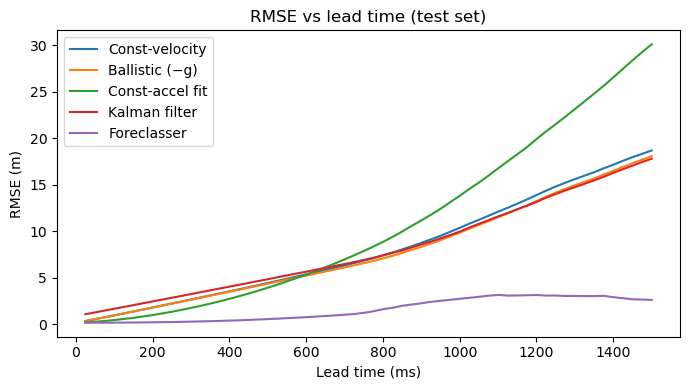

In [28]:
import pandas as pd
N = X_observed_test.shape[0] #Number of time series in the test set
def rmse(a, b, axis=None):
    """
    Function to compute the RMSE of a time series forecast
    """
    return np.sqrt(np.mean((a - b) ** 2, axis=axis))

def zone_mask(x_true, zone=ZONE_X):
    """
    Function that checks if the trajecotry is within the players zone 
    """
    return (x_true >= zone[0]) & (x_true <= zone[1])

def zone_rmse(pred, true, mask):
    """
    Function that computes the RMSE within the players zone 
    """
    return np.sqrt(np.mean((pred[mask] - true[mask]) ** 2))

#constant velocity forecast 
v_est = (X_observed_test[:, -1] - X_observed_test[:, -2]) / DT       
t_grid = np.arange(1, K + 1) * DT                                     
naive_forecast = X_observed_test[:, -1:, :] + v_est[:, None, :] * t_grid[None,:,None]

#Ballistic forecast
x_pred_ball = X_observed_test[:, -1, 0][:, None] + v_est[:,0,None] * t_grid
y_pred_ball = X_observed_test[:, -1, 1][:, None] + v_est[:,1,None] * t_grid - 0.5*G*t_grid**2
ballistic_forecast = np.stack([x_pred_ball, y_pred_ball], axis=2)

#Constant acceleration forecast
t_obs   = np.arange(M) * DT
t_full  = np.arange(M, M+K) * DT
x_ca = []; y_ca = []
for i in range(N):
    cx = np.polyfit(t_obs, X_observed_test[i,:,0], 2)
    cy = np.polyfit(t_obs, X_observed_test[i,:,1], 2)
    x_ca.append(np.polyval(cx, t_full))
    y_ca.append(np.polyval(cy, t_full))
ca_forecast = np.stack([x_ca, y_ca], axis=2)          

#Kalman filter 
# state s=[x,y,vx,vy];  z=[x,y]
A = np.array([[1,0,DT,0],
              [0,1,0,DT],
              [0,0,1,0 ],
              [0,0,0,1 ]], float)
u = np.array([0, -0.5*G*DT**2, 0, -G*DT])
Q = np.diag([1e-4,1e-4,1e-2,1e-2])
H = np.array([[1,0,0,0],
              [0,1,0,0]], float)
R = np.eye(2)*0.15**2

def kf_one(obs):
    vx0 = (obs[1,0]-obs[0,0]) / DT
    vy0 = (obs[1,1]-obs[0,1]) / DT
    s   = np.array([obs[1,0], obs[1,1], vx0, vy0])
    P   = np.eye(4)*1e-2
    for t in range(2, M):
        s = A @ s + u
        P = A @ P @ A.T + Q
        y = obs[t] - H @ s
        S = H @ P @ H.T + R
        Kk= P @ H.T @ np.linalg.inv(S)
        s = s + Kk @ y
        P = (np.eye(4)-Kk@H) @ P
    out = np.empty((K,2))
    for k in range(K):
        s = A @ s + u
        out[k] = s[:2]
    return out
kf_forecast = np.stack([kf_one(X_observed_test[i]) for i in range(N)], axis=0)

#Compute RMSE
methods = {
    "Const-velocity":   naive_forecast,
    "Ballistic (−g)":   ballistic_forecast,
    "Const-accel fit":  ca_forecast,
    "Kalman filter":    kf_forecast,
    "Foreclasser":      mean_forecast
}
rows = []
mask_zone = zone_mask(X_forecast_test[...,0])
for name, pred in methods.items():
    rows.append({
        "method": name,
        "RMSE_all":   rmse(pred, X_forecast_test),
        "RMSE_zone":  zone_rmse(pred, X_forecast_test, mask_zone)
    })
df = pd.DataFrame(rows).set_index("method").sort_values("RMSE_all")
display(df.style.format("{:.3f}"))

#Plots
ms = np.arange(1, K+1)*DT*1000
plt.figure(figsize=(7,4))
for name,pred in methods.items():
    plt.plot(ms, rmse(pred, X_forecast_test, axis=(0,2)), label=name)
plt.xlabel("Lead time (ms)"); plt.ylabel("RMSE (m)")
plt.title("RMSE vs lead time (test set)")
plt.legend(); plt.tight_layout(); plt.show()


In [29]:
welford_layer = model.get_layer("Welford")
means = welford_layer.stats[..., 0].numpy()    
variances = welford_layer.stats[..., 1].numpy() 
counts = welford_layer.count.numpy()           
print("Means shape:", means.shape)
print("Variances shape:", variances.shape)
print("Counts shape:", counts.shape)
print("\nSample values from Welford stats:")
for i in range(min(5, means.shape[0])):  
    print(f"Series {i}:")
    print("  Means:   ", means[i])
    print("  Variances:", variances[i])
    print("  Count:   ", counts[i])

Means shape: (10000, 60, 2)
Variances shape: (10000, 60, 2)
Counts shape: (10000,)

Sample values from Welford stats:
Series 0:
  Means:    [[ 2.3747370e+00  1.7439741e+00]
 [ 2.5816162e+00  1.7996525e+00]
 [ 2.8220000e+00  1.7941593e+00]
 [ 3.0757947e+00  1.8264110e+00]
 [ 3.3024473e+00  1.8297089e+00]
 [ 3.5029166e+00  1.8675332e+00]
 [ 3.7529454e+00  1.8280587e+00]
 [ 3.9537978e+00  1.8375860e+00]
 [ 4.2143264e+00  1.8420750e+00]
 [ 4.4402795e+00  1.7822995e+00]
 [ 4.6564951e+00  1.8053678e+00]
 [ 4.9035258e+00  1.7832608e+00]
 [ 5.1201367e+00  1.7485789e+00]
 [ 5.3445382e+00  1.6708857e+00]
 [ 5.5664511e+00  1.6531655e+00]
 [ 5.8230448e+00  1.5786018e+00]
 [ 5.9990706e+00  1.5449505e+00]
 [ 6.2672086e+00  1.4301815e+00]
 [ 6.4683137e+00  1.3727740e+00]
 [ 6.6780248e+00  1.3057774e+00]
 [ 6.9277329e+00  1.1656797e+00]
 [ 7.1220822e+00  1.1008456e+00]
 [ 7.3553872e+00  9.8961818e-01]
 [ 7.5772381e+00  8.6868167e-01]
 [ 7.8321209e+00  8.2136142e-01]
 [ 8.0107288e+00  6.9318736e-01]
 [